<a href="https://colab.research.google.com/github/gconsulting78-debug/machine-learning-zoomcamp-Capstone2/blob/main/Capstone2_Deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  print('GPU device not found. Check your runtime settings!')
else:
  print('Found GPU at: {}'.format(device_name))

# Check Python version (Colab usually runs 3.10+)
import sys
print("Python version:", sys.version)

Found GPU at: /device:GPU:0
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Model saved to:
# '/content/drive/MyDrive/best_frozen_model.keras'

Mounted at /content/drive


In [ ]:
mkdir -p /content/Capstone2/

In [ ]:
!unzip -q "/content/drive/MyDrive/MLZoomCamp/Capstone2/Dataset.zip" -d  /content/Capstone2/dataset

In [ ]:
!pip install -q gradio  # -q means "quiet" (hides the long installation text)

In [ ]:
train_directory = "/content/Capstone2/dataset/Train"
val_directory = "/content/Capstone2/dataset/Validation"

Loading datasets...
Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.

[Check] Batch contains: 19 Fakes and 13 Reals.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Starting training...
Epoch 1/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5053 - loss: 0.9447
Epoch 1: val_accuracy improved from -inf to 0.49807, saving model to /content/drive/MyDrive/MLZoomCamp/Capstone2/best_model_finetuned.keras
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 581s 128ms/step - accuracy: 0.5053 - loss: 0.9447 - val_accuracy: 0.4981 - val_loss: 0.6908
Epoch 2/50
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5354 - loss: 0.7556
Epoch 2: val_accuracy improved from 0.49807 to 0.58316, saving model to /content/drive/MyDrive/MLZoomCamp/Capstone2/best_model_finetuned.keras
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 503s 115ms/step - accuracy: 0.5354 - loss: 0.7556 - val_accuracy: 0.5832 - val_loss: 0.6702
Epoch 3/50
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 

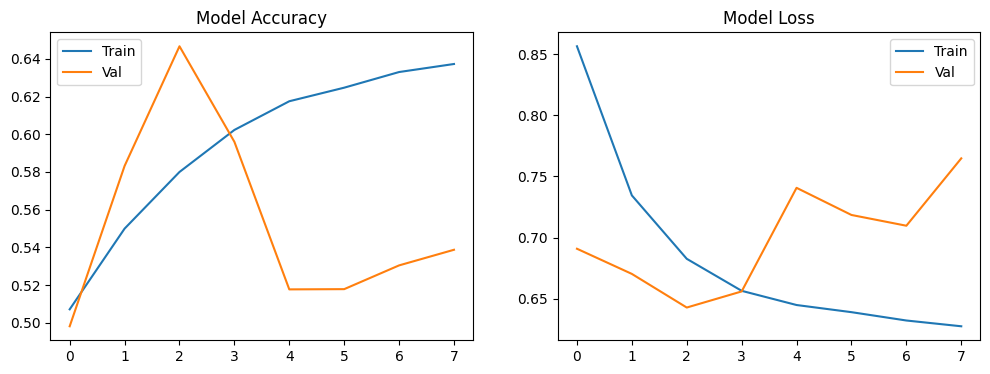

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. CONFIGURATION ---
CONFIG = {
    "IM_SIZE": 224,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 1e-4,  # Lower rate is essential for fine-tuning
    "EPOCHS": 50,           # High limit; EarlyStopping will handle the actual end
}


# --- 2. DATA LOADING ---
print("Loading datasets...")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    image_size=(CONFIG["IM_SIZE"], CONFIG["IM_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    image_size=(CONFIG["IM_SIZE"], CONFIG["IM_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False
)

# --- 3. CLASS BALANCE CHECK (SANITY CHECK) ---
# This verifies if the 50% accuracy was a data loading issue
for images, labels in train_dataset.take(1):
    fakes = np.sum(labels.numpy()[:, 0])
    reals = np.sum(labels.numpy()[:, 1])
    print(f"\n[Check] Batch contains: {int(fakes)} Fakes and {int(reals)} Reals.")
    if fakes == 0 or reals == 0:
        print("WARNING: Batch is imbalanced. Check your folder structure!")

# Apply prefetching for speed
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# --- 4. DATA AUGMENTATION ---
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation_layer")

# --- 5. MODEL BUILDING (FINE-TUNING) ---
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(CONFIG["IM_SIZE"], CONFIG["IM_SIZE"], 3)
)

# Unfreeze the top layers
base_model.trainable = True
for layer in base_model.layers[:-30]: # Keep only the last 30 layers trainable
    layer.trainable = False

model = models.Sequential([
    layers.Input(shape=(CONFIG["IM_SIZE"], CONFIG["IM_SIZE"], 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["LEARNING_RATE"]),
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# --- 6. CALLBACKS (EARLY STOPPING & CHECKPOINT) ---
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,               # Give it 5 epochs to improve
    verbose=1,
    restore_best_weights=True # Returns to the best model version
)

checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/MLZoomCamp/Capstone2/best_model_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# --- 7. TRAINING ---
print("\nStarting training...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIG["EPOCHS"],
    callbacks=[early_stopping, checkpoint_callback]
)

# --- 8. PLOT RESULTS ---
def plot_results(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

plot_results(history)

Found 10905 files belonging to 2 classes.
Class names: ['Fake', 'Real']
Generating predictions...
341/341 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step
Extracting true labels...

Classification Report:
              precision    recall  f1-score   support

        Fake       0.75      0.42      0.54      5492
        Real       0.59      0.85      0.70      5413

    accuracy                           0.64     10905
   macro avg       0.67      0.64      0.62     10905
weighted avg       0.67      0.64      0.62     10905



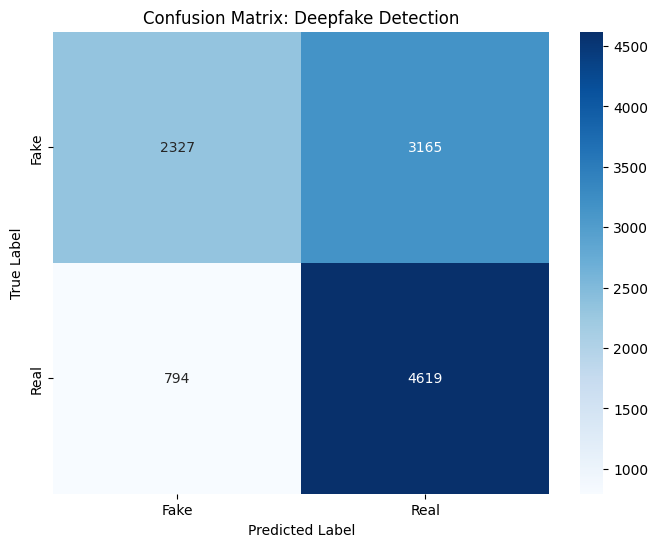

In [ ]:
# MODEL TESTING
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report # Added import
import matplotlib.pyplot as plt # Added import for plotting
import seaborn as sns # Added import for heatmap

TESTDATA = '/content/Capstone2/dataset/Test'


# 1. LOAD DATASET (Keep the raw dataset in a temporary variable first)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    TESTDATA,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

# 2. EXTRACT CLASS NAMES NOW (Before prefetching)
class_names = raw_test_ds.class_names
print(f"Class names: {class_names}")

# 3. NOW APPLY PREFETCH FOR SPEED
test_dataset = raw_test_ds.prefetch(tf.data.AUTOTUNE)

# 4. PREDICT
print("Generating predictions...")
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# 5. GET TRUE LABELS
# We use the raw dataset or the prefetched one; both work for iteration
print("Extracting true labels...")
y_true_categorical = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true_categorical, axis=1)

# 5. COMPUTE CONFUSION MATRIX
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 6. PRINT CLASSIFICATION REPORT
# This gives you Precision, Recall, and F1-score for your Capstone
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 7. PLOT HEATMAP
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Deepfake Detection')
plt.show()

In [ ]:
# Check label distribution in a batch
for images, labels in train_dataset.take(1):
    print("Labels in one batch:", np.argmax(labels, axis=1))
    # You should see a mix of 0s and 1s

Labels in one batch: [1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0]


In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr
import numpy as np

def predict_image(img):
    # 1. Resize the image to match model input
    img = tf.image.resize(img, (224, 224))

    # 2. Add batch dimension and rescale
    img_array = tf.expand_dims(img, 0) / 255.0

    # 3. Predict
    prediction = model.predict(img_array)[0]

    # 4. Map back to class names
    # Returns a dictionary like {"Fake": 0.25, "Real": 0.75}
    return {class_names[i]: float(prediction[i]) for i in range(2)}

# Test it locally with the Gradio Interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=2),
    title="Deepfake Detector",
    description="Upload an image to check if it is Real or a Deepfake."
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8667c97f9022c302cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
